<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393 Máquinas de Aprendizaje II-2018 </h1>

<H3 align='center'> Tarea 3 - Ensamblados y modelos avanzados </H3>
<H4 align='center'> Pablo Aguirre, Jorge Aliste </H4>
<hr style="height:2px;border:none"/>

## 2. Redes Convolucionales sobre imágenes
---
Las redes neuronales hoy en día han sido extendidas a numerosas aplicaciones gracias a la arquitectura definida para cada tipo de problema. Las redes neuronales que aplican la operación de convolución [[3]](#refs) o convoluciones en sus capas son concidas como *CNN* o *ConvNets*, lo cual se especializa en trabajar en datos con forma matricial (ya sea bi-dimensional o tri-dimensional), lo cual se adecúa perfectamente a imágenes (matrices), ya que gracias a su conectividad local se especializan en reconocer patrones sobre los datos de manera espacial, como refleja la siguiente imagen:

<img src="https://cdn-images-1.medium.com/max/1600/1*N4h1SgwbWNmtrRhszM9EJg.png" title="Title text" width="90%" />


En esta actividad trabajará con un extracto bastante pequeño del dataset conocido como **101-Food**[[4]](#refs), el cual consta de mil imágenes pertenecientes a 3 clases (*Hambuger, Hot Dog* y *Pizza*) separados en conjunto de entrenamiento y validación.  
El extracto pequeño del dataset con el que se trabajará deberá ser descargado del siguiente __[link](https://www.dropbox.com/s/56xqazmhbh0doi7/food_data.zip?dl=0)__ a través de Dropbox.

In [16]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import *
from sklearn.metrics import confusion_matrix 
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


> a) Construya funciones para leer los datos y cargarlos al momento de entrenar (durante cada *epoch*), para ésto utilice *Image Data Generator* de keras.

In [2]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255) #no transformation
train_generator = train_datagen.flow_from_directory(
        'food_data/train',
        target_size=(150, 150),
        color_mode='rgb',
        batch_size=32)
validation_generator = test_datagen.flow_from_directory(
        'food_data/val',
        target_size=(150, 150),
        color_mode='rgb',
        batch_size=32)

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


Se tienen 2400 registros en el conjunto de entrenamiento y 600 en el conjunto de validación.

> b) Utilice la red tradicional (*Feed Forward*) entregada en el código para ser entrenada sobre los datos vectorizados, esto es que cada imagen queda representada como un vector gigante, y las 3 clases a las que se enfrenta. Evalúe el modelo con la métrica *accuracy* sobre el conjunto de validación.

In [4]:
modelFF = Sequential()
modelFF.add(Flatten(input_shape=train_generator.image_shape)) #full dense
modelFF.add(BatchNormalization()) #to normalize the input..
modelFF.add(Dense(256,activation='relu'))
modelFF.add(Dropout(0.25))
modelFF.add(Dense(128,activation='relu')) #128
modelFF.add(Dropout(0.25))
modelFF.add(Dense(3,activation='softmax'))
modelFF.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy']) # Let's train the model using RMSprop
modelFF.summary()
modelFF.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator.classes)//train_generator.batch_size, #samples//batch_size
        epochs=25,
        validation_data=validation_generator,
        validation_steps=len(validation_generator.classes)//validation_generator.batch_size, verbose=1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 67500)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 67500)             270000    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               17280256  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total para

In [5]:
print("Accuracy validation: ",modelFF.evaluate_generator(generator=validation_generator, steps=len(validation_generator.classes)//validation_generator.batch_size)[1])

Accuracy validation:  0.4665492961943989


El accuracy obtenido usando una red neuronal Feed Forward es bastante bajo considerando que solo se tienen 3 clases.

La matriz de confusión correspondiente es

Normalized confusion matrix
[[0.21  0.13  0.66 ]
 [0.265 0.185 0.55 ]
 [0.265 0.13  0.605]]


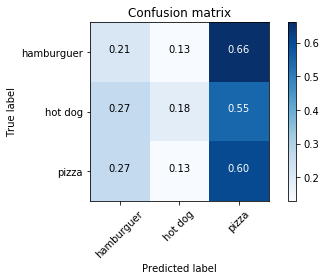

In [22]:
Y_pred = modelFF.predict_generator(validation_generator,len(validation_generator.classes)//validation_generator.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
confusion_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.figure()

plot_confusion_matrix(confusion_matrix, ["hamburguer", "hot dog", "pizza"], normalize=True)

plt.show()

Se observa una fuerte tendencia a predecir pizza independientemente de la imágen que se le entregue.

> c) Utilice la red convolucional (**CNN**) entregada en el código para ser entrenada sobre los datos brutos, matrices RGB de píxeles, y las 3 clases a las que se enfrenta. Evalúe el modelo con la métrica *accuracy* sobre el conjunto de validación. Compare.

In [6]:
modelC = Sequential()
modelC.add(Conv2D(32, (3, 3), padding='same',input_shape=train_generator.image_shape,activation='relu'))
modelC.add(Conv2D(32, (3, 3),activation='relu'))
modelC.add(MaxPool2D(pool_size=(2, 2)))
modelC.add(Dropout(0.25))
modelC.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
modelC.add(Conv2D(64, (3, 3),activation='relu'))
modelC.add(MaxPool2D(pool_size=(2, 2)))
modelC.add(Dropout(0.25))
modelC.add(Flatten())
modelC.add(Dense(128,activation='relu'))
modelC.add(Dropout(0.5)) 
modelC.add(Dense(len(train_generator.class_indices),activation='softmax'))
modelC.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy']) # Let's train the model using RMSprop
modelC.summary()
modelC.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator.classes)//train_generator.batch_size, #samples//batch_size
        epochs=25,
        validation_data=validation_generator,
        validation_steps=len(validation_generator.classes)//validation_generator.batch_size, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 148, 148, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 74, 74, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
__________

In [7]:
print("Accuracy validation: ",modelC.evaluate_generator(generator=validation_generator, steps=len(validation_generator.classes)//validation_generator.batch_size)[1])

Accuracy validation:  0.704225352112676


Es posible observar que el accuracy obtenido con la CNN es mayor que el de la red tradicional por lo que es correcto pensar que las CNN son mejores cuando los datos son imágenes.

La matriz de confusión correspondiente es

Normalized confusion matrix
[[0.215 0.35  0.435]
 [0.25  0.355 0.395]
 [0.215 0.32  0.465]]


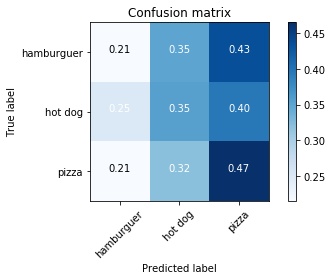

In [18]:
Y_pred2 = modelC.predict_generator(validation_generator,len(validation_generator.classes)//validation_generator.batch_size+1)
y_pred2 = np.argmax(Y_pred2, axis=1)
confusion_matrix2 = confusion_matrix(validation_generator.classes, y_pred2)

plt.figure()

plot_confusion_matrix(confusion_matrix2, ["hamburguer", "hot dog", "pizza"], normalize=True)

plt.show()

Se puede ver que el modelo tiende más a predecir hot dog y pizza.

> d) Genere un conjunto datos con incorrecta etiquetación de manera manual y vea si el modelo convolucional se sigue comportando de la misma manera. Para esto tome 100 imágenes aleatorias de entrenamiento de la carpeta *hot dog* y 100 imágenes aleatorias de entrenamiento de la carpeta *hamburger* e intercambielas, sin manipular las imágenes de la carpeta *pizza* y con el conjunto de validación intacto. Genere las matrices de confusión en el conjunto de validación para visualizar cómo afectó al modelo la corrupción realizada a los datos.

In [8]:
train_datagen2 = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_generator2 = train_datagen2.flow_from_directory(
        'food_data/train2',
        target_size=(150, 150),
        color_mode='rgb',
        batch_size=32)

Found 2400 images belonging to 3 classes.


In [9]:
modelC2 = Sequential()
modelC2.add(Conv2D(32, (3, 3), padding='same',input_shape=train_generator2.image_shape,activation='relu'))
modelC2.add(Conv2D(32, (3, 3),activation='relu'))
modelC2.add(MaxPool2D(pool_size=(2, 2)))
modelC2.add(Dropout(0.25))
modelC2.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
modelC2.add(Conv2D(64, (3, 3),activation='relu'))
modelC2.add(MaxPool2D(pool_size=(2, 2)))
modelC2.add(Dropout(0.25))
modelC2.add(Flatten())
modelC2.add(Dense(128,activation='relu'))
modelC2.add(Dropout(0.5)) 
modelC2.add(Dense(len(train_generator2.class_indices),activation='softmax'))
modelC2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy']) # Let's train the model using RMSprop
modelC2.summary()
modelC2.fit_generator(
        train_generator2,
        steps_per_epoch=len(train_generator2.classes)//train_generator2.batch_size, #samples//batch_size
        epochs=25,
        validation_data=validation_generator,
        validation_steps=len(validation_generator.classes)//validation_generator.batch_size, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 148, 148, 32)      9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 74, 74, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
__________

In [20]:
print("Accuracy validation: ",modelC2.evaluate_generator(generator=validation_generator, steps=len(validation_generator.classes)//validation_generator.batch_size)[1])

Accuracy validation:  0.6654929569069769


El error de validación es un poco menor que cuando no se cambian las imágenes.

La matriz de confusión correspondiente es

Normalized confusion matrix
[[0.385 0.25  0.365]
 [0.385 0.2   0.415]
 [0.345 0.22  0.435]]


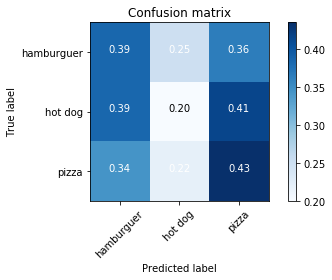

In [17]:
Y_pred3 = modelC2.predict_generator(validation_generator,len(validation_generator.classes)//validation_generator.batch_size+1)
y_pred3 = np.argmax(Y_pred3, axis=1)
confusion_matrix3 = confusion_matrix(validation_generator.classes, y_pred3)

plt.figure()

plot_confusion_matrix(confusion_matrix3, ["hamburguer", "hot dog", "pizza"], normalize=True)

plt.show()

En este caso, el comportamiento es distinto a la CNN anterior. Tiende a predecir pizza o hamburguesa con probabilidades similares, por lo que intercambiar las imágenes entre hot dogs y hamburguesas si tuvo un efecto en el entrenamiento.